# Проект стартапы.

Нам предстоит работа с данными о стартапах, функционировавших в период с 1970 по 2018 годы. Цель работы предсказать, какие из них закроются и применить для этого свои знания в области анализа данных и машинного обучения.

### Загрузка данных.

**Описание данных**

В нашем распоряжении три файла:

- `sample.csv` - файл с примером предсказаний в правильном формате
- `train.csv` - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных
- `test.csv` - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение `status` для каждого стартапа из этого датасета

Для этой задачи были предоставлены данные с признаками:

- `name` - название стартапа
- `category_list` - список категорий, к которым относится стартап
- `funding_total_usd` - общая сумма финансирования в USD
- `status` - статус стартапа (закрыт или действующий) (целевой признак)
- `country_code` - код страны
- `state_code` - код штата
- `region` - регион
- `city` - город
- `funding_rounds` - количество раундов финансирования
- `founded_at` - дата основания
- `first_funding_at` - дата первого раунда финансирования
- `last_funding_at` - дата последнего раунда финансирования
- `closed_at` - дата закрытия стартапа (если применимо)
- `lifetime` - время существования стартапа в днях

#### Импортируем библиотеки.

In [355]:
pip install phik -q

In [356]:
pip install optuna -q

In [357]:
pip install optuna-integration -q

In [358]:
# pip install scikit-learn==1.3.0. -q

In [359]:
pip install catboost -q

In [360]:
pip install imbalanced-learn -q

In [361]:
pip install shap -q

In [362]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
import math
import warnings
import shap

from phik.report import plot_correlation_matrix
from scipy import stats as st
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC, RandomOverSampler

from optuna import distributions
from optuna.integration import OptunaSearchCV

from catboost import CatBoostClassifier
from catboost import cv, Pool

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR

from sklearn.metrics import (
    confusion_matrix,
    f1_score
)

pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', None)
RANDOM_STATE = 42
TEST_SIZE = 0.25
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(12, 6)})

#### Считаем данные датафреймов и запишем в переменные `sample`, `train`, `test`.

In [363]:
sample = pd.read_csv('/content/drive/MyDrive/DS/start_up/sample.csv', sep = ',', decimal = '.', skipinitialspace=True)
train = pd.read_csv('/content/drive/MyDrive/DS/start_up/train.csv', sep = ',', decimal = '.', skipinitialspace=True)
test = pd.read_csv('/content/drive/MyDrive/DS/start_up/test.csv', sep = ',', decimal = '.', skipinitialspace=True)


#### Обзор данных `train`.

Выведем первые десять строк таблицы на экран.

In [364]:
train.head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,"828,626.000",operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,"42,935,019.000",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,"35,456,381.000",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,"22,250,000.000",operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN
5,Connected Sports Ventures,Mobile,"4,300,000.000",operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,NaN
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,"90,000,000.000",operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaN
7,Mesh Networks,Software,"4,300,000.000",operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaN
8,AngioScore,Biotechnology,"42,000,000.000",operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaN
9,Vidatronic,Semiconductors,"1,250,500.000",operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaN


Таблица содержит информацию о стартапах, которые будут использоваться в качестве обучающих данных.

Выведем основную информацию о датафрейме `train` с помощью метода `info()`.

In [365]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


В таблице 52516 строк и 13 столбцов. Во всех столбцах кроме `funding_rounds`, `founded_at`, `first_funding_at` и `last_funding_at` есть пропущеные значения. Необходимо изменить типы данных в столбцах `founded_at`, `first_funding_at`, `last_funding_at` и `closed_at` на `datetime64`.

#### Обзор данных `test`.


Выведем первые десять строк таблицы на экран.

In [366]:
test.head(10)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,"2,819,200.000",NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,"428,257.000",LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,"34,700,000.000",USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,"4,530,000.000",CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209
5,Quickfire Games,Design|Entertainment|Games,"160,000.000",NaN,NaN,NaN,NaN,2,2013-09-18,2014-09-18,1583
6,Sente Inc.,Biotechnology,"26,842,000.000",USA,CA,San Diego,Encinitas,5,2009-01-31,2014-06-02,4018
7,Triosyn,Health Care|Medical|Therapeutics,"4,000,000.000",NaN,NaN,NaN,NaN,1,2003-06-02,2003-06-02,5576
8,Urgent.ly,Software,"8,710,000.000",USA,VA,"Washington, D.C.",Sterling,3,2014-04-17,2015-09-29,1826
9,Map Decisions,Software,"13,200.000",USA,PA,Allentown,Bethlehem,1,2013-08-09,2013-08-09,2057


Таблица содержит информацию о стартапах, которые будут использоваться в качестве тестовых данных. Необходимо предсказать значение `status` для каждого стартапа из датасета.

Выведем основную информацию о датафрейме `test` с помощью метода `info()`.

In [367]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


В таблице 13125 строк и 11 столбцов. Во всех столбцах кроме `name`, `funding_rounds`, `first_funding_at`, `last_funding_at` и `lifetime` есть пропущеные значения. Необходимо изменить типы данных в столбцах `first_funding_at` и `last_funding_at` на `datetime64`.

#### Выводы.

В таблице `train` во всех столбцах кроме `funding_rounds`, `founded_at`, `first_funding_at` и `last_funding_at` есть пропущеные значения. Необходимо изменить типы данных в столбцах `founded_at`, `first_funding_at`, `last_funding_at` и `closed_at` на `datetime64`.

В таблице `test` во всех столбцах кроме `name`, `funding_rounds`, `first_funding_at`, `last_funding_at` и `lifetime` есть пропущеные значения. Необходимо изменить типы данных в столбцах `first_funding_at` и `last_funding_at` на `datetime64`.

### Предобработка данных.



#### Изучим пропущенные значения в датафреймах.

Проверим значения в таблице `train`.


In [368]:
train.isna().sum()

,0
name,1
category_list,2465
funding_total_usd,10069
status,0
country_code,5502
state_code,6763
region,6359
city,6359
funding_rounds,0
founded_at,0


Заполним заглушкой столбцы `name`, `category_list`, `country_code`, `state_code`, `region` и `city`.

In [369]:
train['name'] = train['name'].fillna('unknown')
train['category_list'] = train['category_list'].fillna('unknown')
train['country_code'] = train['country_code'].fillna('unknown')
train['state_code'] = train['state_code'].fillna('unknown')
train['region'] = train['region'].fillna('unknown')
train['city'] = train['city'].fillna('unknown')

Заполним медианой пропущенные значения в столбце `funding_total_usd`.

In [370]:
train['funding_total_usd'] = train['funding_total_usd'].fillna(train['funding_total_usd'].median())

Проверим значения в таблице `test`.


In [371]:
test.isna().sum()

,0
name,0
category_list,591
funding_total_usd,2578
country_code,1382
state_code,1695
region,1589
city,1587
funding_rounds,0
first_funding_at,0
last_funding_at,0


Заполним заглушкой столбцы `category_list`, `country_code`, `state_code`, `region` и `city`.

In [372]:
test['category_list'] = test['category_list'].fillna('unknown')
test['country_code'] = test['country_code'].fillna('unknown')
test['state_code'] = test['state_code'].fillna('unknown')
test['region'] = test['region'].fillna('unknown')
test['city'] = test['city'].fillna('unknown')

Заполним медианой пропущенные значения в столбце `funding_total_usd`.

In [373]:
test['funding_total_usd'] = test['funding_total_usd'].fillna(test['funding_total_usd'].median())

#### Изучим дубликаты в датафреймах.

In [374]:
train.duplicated().sum()

0

In [375]:
test.duplicated().sum()

0

Явных дубликатов не обнаружено.

##### Проверим наличие неявных дубликатов.

Проверим неявные дубликаты в таблице `train`.


In [376]:
train['name'].duplicated().sum()

0

In [377]:
train['status'].unique()

array(['operating', 'closed'], dtype=object)

In [378]:
train['country_code'].unique()

array(['CHE', 'USA', 'unknown', 'GBR', 'RUS', 'ESP', 'FRA', 'SWE', 'IND',
       'KOR', 'AUS', 'TWN', 'CHN', 'HUN', 'CAN', 'FIN', 'BRA', 'EGY',
       'PRT', 'ISR', 'CHL', 'SVK', 'NLD', 'ARG', 'ARE', 'JPN', 'IRL',
       'DEU', 'LBN', 'EST', 'IDN', 'BEL', 'MEX', 'DNK', 'ITA', 'GRC',
       'ROM', 'TUR', 'SGP', 'SAU', 'MYS', 'NGA', 'QAT', 'VNM', 'BGR',
       'GHA', 'UGA', 'JOR', 'AUT', 'PAK', 'NZL', 'HKG', 'ZAF', 'LVA',
       'NOR', 'HRV', 'VEN', 'PER', 'LUX', 'SVN', 'POL', 'PHL', 'NIC',
       'CZE', 'ISL', 'PAN', 'URY', 'BGD', 'MCO', 'GTM', 'THA', 'TTO',
       'UKR', 'KEN', 'CRI', 'DZA', 'LTU', 'CYM', 'MUS', 'BLR', 'SLV',
       'COL', 'MLT', 'PSE', 'BLZ', 'CYP', 'MMR', 'MKD', 'KHM', 'GIB',
       'SRB', 'DOM', 'BWA', 'BLM', 'PRY', 'BMU', 'TAN', 'LIE', 'GRD',
       'UZB', 'GEO', 'SEN', 'ALB', 'ECU', 'MOZ', 'LKA', 'LAO', 'TUN',
       'HND', 'ZWE', 'BAH', 'MDA', 'MAF', 'BHR', 'AZE', 'MAR', 'KWT',
       'IRN', 'GGY', 'KNA', 'PRI', 'OMN', 'KAZ', 'JAM', 'NPL', 'ARM',
       'TGO', 'R

In [379]:
train['state_code'].unique()

array(['25', 'CA', 'unknown', 'VA', 'NJ', 'TX', 'OR', 'FL', 'WA', 'NY',
       'C7', 'AZ', '91', 'GA', 'MA', 'PA', 'MI', '56', 'MN', 'A8', 'DE',
       '26', 'Q5', '7', 'RI', '11', 'C5', 'CO', '3', '23', '1', 'ON',
       'IL', 'OH', 'K2', '2', '14', '30', 'H9', 'AL', '29', '6', 'NC',
       '5', '12', '22', 'MD', '48', 'ND', '40', 'K4', 'VT', '16', '4',
       'UT', 'IN', '8', '9', '18', 'CT', '13', 'NV', '10', 'B8', '27',
       '17', 'IA', 'WI', 'L9', 'NM', 'B7', 'MO', 'BC', '21', 'F7', 'ME',
       'NH', '35', 'NS', 'C1', 'C3', 'SC', '20', 'TN', 'A6', '51', 'I7',
       'LA', 'KS', '42', 'N7', 'U8', 'I2', 'AR', '19', 'NE', '41', 'QC',
       'AB', '37', '15', '97', 'V2', 'D2', 'DC', 'A7', 'C9', 'F8', 'Y2',
       'B9', 'J7', 'M9', 'G2', 'H3', 'ID', 'NB', '28', 'V8', '34', 'B5',
       'F2', 'A9', 'Z7', '53', 'H8', 'MT', 'MB', 'KY', '61', '60', 'B4',
       'H7', '82', 'A2', 'C8', 'L3', 'B3', 'D9', 'M3', 'MS', '31', '33',
       '52', 'HI', 'AK', '78', '72', 'Q4', 'Y4', 'WY', '32', 

В таблице `train` неявных дубликатов не обнаружено.

Проверим неявные дубликаты в таблице `test`.

In [380]:
test['name'].duplicated().sum()

0

In [381]:
test['country_code'].unique()

array(['NIC', 'USA', 'LUX', 'CAN', 'unknown', 'MYS', 'DEU', 'GBR', 'FRA',
       'ITA', 'CHN', 'ARG', 'NLD', 'IRL', 'AUS', 'CHE', 'CHL', 'ESP',
       'IND', 'ISR', 'DNK', 'KOR', 'RUS', 'PHL', 'URY', 'SGP', 'BRA',
       'EGY', 'MEX', 'POL', 'VNM', 'AUT', 'EST', 'BEL', 'DMA', 'PRT',
       'SWE', 'JOR', 'HUN', 'HKG', 'JPN', 'ZAF', 'COL', 'BGR', 'CZE',
       'GRC', 'LTU', 'TWN', 'ISL', 'IDN', 'FIN', 'NOR', 'ARE', 'UKR',
       'KEN', 'NGA', 'TUR', 'CRI', 'THA', 'CYP', 'ROM', 'MMR', 'VEN',
       'BHR', 'NZL', 'SVK', 'CYM', 'LVA', 'MKD', 'PER', 'AZE', 'BWA',
       'BGD', 'ZWE', 'CIV', 'LKA', 'SVN', 'SRB', 'BLR', 'TAN', 'SAU',
       'GHA', 'CMR', 'TTO', 'PAK', 'BMU', 'PSE', 'UGA', 'MUS', 'JAM',
       'LBN', 'ECU', 'PAN', 'GTM', 'HRV', 'BRB', 'ZMB'], dtype=object)

In [382]:
test['state_code'].unique()

array(['17', 'TN', '3', 'CA', 'ON', 'unknown', 'VA', 'PA', 'AZ', '14',
       '7', 'AL', 'MA', 'NY', '16', 'H9', 'GA', 'I9', 'QC', 'FL', 'WA',
       'OH', 'CO', 'A8', 'MS', '18', '22', 'DC', 'NC', 'C7', '15', '4',
       '2', 'TX', '24', '12', '51', '36', 'MO', '5', 'H3', '19', '23',
       'NJ', 'MD', 'K2', 'MI', '11', '9', '48', 'D9', 'B3', 'IN', 'KS',
       '10', 'A6', 'SC', 'UT', 'OR', 'IL', '28', 'BC', '56', '78', 'LA',
       '1', 'A9', '29', '13', 'RI', 'B6', 'MN', 'U8', 'V2', 'CT', 'KY',
       'WI', '26', 'P6', 'NM', '72', 'IA', '8', 'NV', 'E2', 'I2', 'ME',
       '86', '25', '30', 'B7', 'AB', '40', '60', 'Z3', 'NE', '34', 'Z7',
       'A3', '59', 'VT', '52', '35', 'B4', '65', 'Q4', '6', 'NH', 'AR',
       'M3', 'I6', 'A7', 'DE', 'NL', 'P4', 'F8', '27', 'C9', '42', 'MB',
       'B9', 'I7', '79', 'J8', 'L3', 'J1', 'C3', 'WV', '31', 'MT', '58',
       'N7', 'P8', 'F4', '32', 'I5', 'OK', 'W1', '53', 'G8', 'K7', 'T5',
       'H2', '20', 'NS', 'E9', 'HI', 'F7', 'F2', '82', 'ND', 

В таблице `test` неявных дубликатов не обнаружено.

#### Изменим формат данных в таблицах.

В таблице `train` изменим типы данных в столбцах `founded_at`, `first_funding_at`, `last_funding_at` и `closed_at` на `datetime64`.

In [383]:
train['founded_at'] = pd.to_datetime(train['founded_at']).dt.normalize()
train['first_funding_at'] = pd.to_datetime(train['first_funding_at']).dt.normalize()
train['last_funding_at'] = pd.to_datetime(train['last_funding_at']).dt.normalize()
train['closed_at'] = pd.to_datetime(train['closed_at']).dt.normalize()

Проверим результат.

In [384]:
train.dtypes

,0
name,object
category_list,object
funding_total_usd,float64
status,object
country_code,object
state_code,object
region,object
city,object
funding_rounds,int64
founded_at,datetime64[ns]


Типы данных успешно изменены.

В таблице `test` изменим типы данных в столбцах `first_funding_at`, `last_funding_at` на `datetime64`.

In [385]:
test['first_funding_at'] = pd.to_datetime(test['first_funding_at']).dt.normalize()
test['last_funding_at'] = pd.to_datetime(test['last_funding_at']).dt.normalize()

Проверим результат.

In [386]:
test.dtypes

,0
name,object
category_list,object
funding_total_usd,float64
country_code,object
state_code,object
region,object
city,object
funding_rounds,int64
first_funding_at,datetime64[ns]
last_funding_at,datetime64[ns]


Типы данных успешно изменены.

#### Проверим количественные значения в таблицах.

Проверим количественные значения столбцов `funding_total_usd` и `funding_rounds` таблицы `train`.

In [387]:
train[['funding_total_usd','funding_rounds']].describe()

,funding_total_usd,funding_rounds
count,"52,516.000","52,516.000"
mean,"15,132,317.988",1.741
std,"168,346,591.353",1.375
min,1.000,1.000
25%,"529,721.250",1.000
50%,"2,000,000.000",1.000
75%,"6,788,929.000",2.000
max,"30,079,503,000.000",19.000


Максимальное значение в столбце `funding_total_usd` сильно выбивается, удалим его.

In [388]:
train = train[train['funding_total_usd'] < 30000000000]

Проверим количественные значения столбцов `funding_total_usd` и `funding_rounds` таблицы `test`.

In [389]:
test[['funding_total_usd','funding_rounds']].describe()

,funding_total_usd,funding_rounds
count,"13,125.000","13,125.000"
mean,"13,691,381.800",1.714
std,"82,827,369.207",1.319
min,1.000,1.000
25%,"501,000.000",1.000
50%,"2,000,000.000",1.000
75%,"6,513,865.000",2.000
max,"4,715,000,000.000",15.000


#### Добавление столбцов.

Добавим столбец `lifetime` в таблицу `train`.

In [390]:
train['lifetime'] = (train['closed_at'] - train['founded_at']).dt.days

train['lifetime'] = train['lifetime'].fillna((pd.to_datetime('2018-01-01') - train['founded_at']).dt.days)

Добавим столбец `lifetime_years` в таблицу `train`.

In [391]:
train['lifetime_years'] = train['lifetime'] / 365.25
train['lifetime_years'] = train['lifetime_years'].astype(int)

Добавим столбец `lifetime_years` в таблицу `test`.

In [392]:
test['lifetime_years'] = test['lifetime'] / 365.25
test['lifetime_years'] = test['lifetime_years'].astype(int)

Добавим столбец `founded_at` в таблицу `test`.

In [393]:
test['founded_at'] = pd.to_datetime('2018-01-01') - pd.to_timedelta(test['lifetime'], unit='D')

Добавим в таблицы столбец `first_funding_days` с количеством дней от даты основания стартапа, до даты первого финансирования.

In [394]:
train['first_funding_days'] = (train['first_funding_at'] - train['founded_at']).dt.days
test['first_funding_days'] = (test['first_funding_at'] - test['founded_at']).dt.days

Добавим в таблицы столбец `last_funding_days` с количеством дней от даты первого финансирования, до даты последнего финансирования.

In [395]:
train['last_funding_days'] = (train['last_funding_at'] - train['first_funding_at']).dt.days
test['last_funding_days'] = (test['last_funding_at'] - test['first_funding_at']).dt.days

Добавим в таблицы столбец `founded_last_funding_days` с количеством дней от даты первого финансирования до даты последнего финансирования.

In [396]:
train['founded_last_funding_days'] = (train['last_funding_at'] - train['founded_at']).dt.days
test['founded_last_funding_days'] = (test['last_funding_at'] - test['founded_at']).dt.days

Добавим в таблицы столбцец `founded_at_year`, где будет указан год основания стартапа.

In [397]:
train['founded_at_year'] = (train['founded_at']).dt.year
test['founded_at_year'] = (test['founded_at']).dt.year

Добавим в таблицы столбцы с годом первого этапа финансирования.

In [398]:
train['first_funding_year'] = (train['first_funding_at']).dt.year
test['first_funding_year'] = (test['first_funding_at']).dt.year


Добавим в таблицы столбцы с годом последнего этапа финансирования.

In [399]:
train['last_funding_year'] = (train['last_funding_at']).dt.year
test['last_funding_year'] = (test['last_funding_at']).dt.year

Добавим столбец `country_state`, в котором будет информация с кодом страны и кодом штата.

In [400]:
train['country_state'] = train['country_code'] + train['state_code']
test['country_state'] = test['country_code'] + test['state_code']

#### Обработка столбца `category_list`.

Создадим новый столбец `top_categories`, куда войдут топ самых популярных категорий.

In [401]:
top_categories_count = pd.Series(train['category_list'].str.split('|').sum()).value_counts().nlargest(664)
top_categories_count.tail(10)

,count
Estimation and Quoting,11
Space Travel,11
Green Building,11
Senior Health,11
Green Consumer Goods,11
EBooks,11
Offline Businesses,11
Quantified Self,11
Gift Registries,11
Early-Stage Technology,10


Было решено взять топ 663 категорий. Категории, где количество стартапов меньше 10 запишем как `other`.

In [402]:
top_categories = pd.Series(train['category_list'].str.split('|').sum()).value_counts().nlargest(663).index

# Функция для получения строки с самыми популярными категориями.
def top_663_categories(row):

    categories = row['category_list'].split('|')
    popular_categories = [cat for cat in top_categories if cat in categories][:1]
    return ', '.join(popular_categories) if popular_categories else 'other'

# Применим функцию к таблицам и создадим новый столбец top_categories
train['top_categories'] = train.apply(top_663_categories, axis=1)
test['top_categories'] = test.apply(top_663_categories, axis=1)

#### Выводы.

В таблице `train` пропущенные значения в столбцах `name`, `category_list`, `country_code`, `state_code`, `region` и `city`, заполнили заглушкой. Столбец `funding_total_usd` заполнили медианой.

В таблице `test` пропущенные значения в столбцах `category_list`, `country_code`, `state_code`, `region` и `city`, заполнили заглушкой. Столбец `funding_total_usd` заполнили медианой.

Явных дубликатов в таблицах не обнаружено.

В таблицах неявных дубликатов не обнаружено.

В таблице `test` изменены типы данных в столбцах `first_funding_at`, `last_funding_at` на `datetime64`.

В таблице `train` изменены типы данных в столбцах `founded_at`, `first_funding_at`, `last_funding_at` и `closed_at` на `datetime64`.

Удален выброс в столбце `funding_total_usd` в таблице `train`.

Добавлен столбец `country_state`, в котором содержится информация с кодом страны и кодом штата.

Добавлен столбец `top_categories`, который содержит самую популярную категорию из указанных компанией.

Добавлены сталбцы с различными вариантами отоброжения значений даты.

### Исследовательский анализ данных.

Напишем функцию для проверки количественных значений.

In [403]:
def check_quan(data, col, bins=20):
    display(data[col].describe())

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

    data[col].plot(kind='hist', bins=bins, ax=axes[0], grid=True)
    axes[0].set_title('Гистограмма распределения', fontsize=14)
    axes[0].set_ylabel('Частота встречаемости')
    axes[0].set_xlabel('Наблюдаемые значения')

    data[col].plot(kind='box', ax=axes[1], rot=0, grid=True)
    axes[1].set_title('Разброс значений признаков', fontsize=14)
    axes[1].set_xlabel('Категория')
    axes[1].set_ylabel('Наблюдаемые значения')
    plt.show()

Напишем функцию для проверки категориальных значений.

In [404]:
def chek_cat_sns(cat):
    ax = sns.countplot(x=train[cat],
                   order=train[cat].value_counts(ascending=False).index);

    labels_values = train[cat].value_counts(ascending=False).values

    ax.bar_label(container=ax.containers[0], labels=labels_values)
    ax.set_title('Распределение категорий признака ' + cat)
    ax.set(xlabel='Категории', ylabel='Частота встречаемости')
    ax.figure.set_size_inches(12,6);

#### Исследовательский анализ данных таблицы `train`.

**Изучим количественные признаки.**

Построим гистограмму распределения по признаку `funding_total_usd`.

,funding_total_usd
count,"52,515.000"
mean,"14,559,826.877"
std,"105,493,478.594"
min,1.000
25%,"529,442.500"
50%,"2,000,000.000"
75%,"6,787,224.000"
max,"10,664,943,639.000"


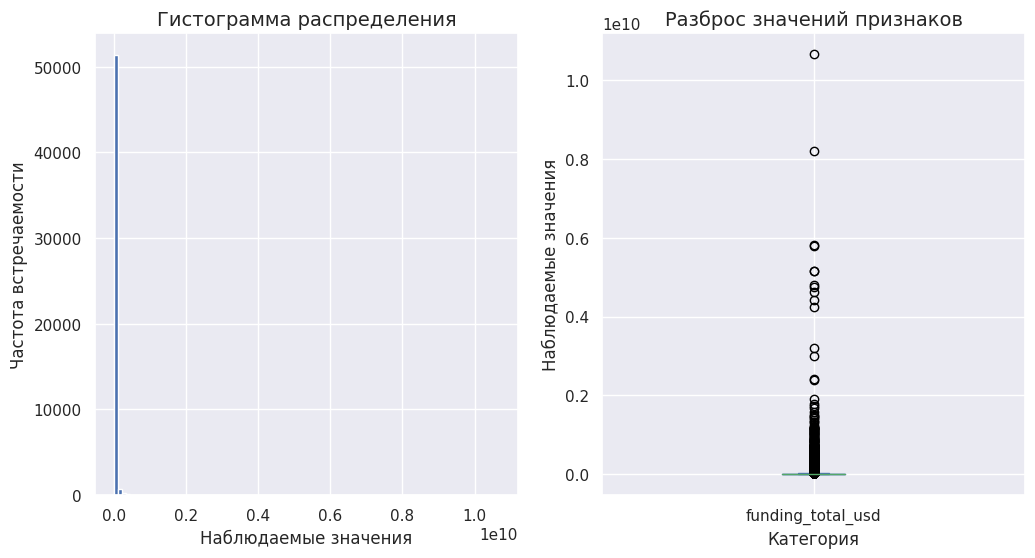

In [405]:
check_quan(train, 'funding_total_usd', bins=100)

Разброс значений очень велик, от 1 до 10,664,943,639. Попробуем построить гистограмму с суммой финансирования менее 100,000,000.

,funding_total_usd
count,"51,206.000"
mean,"7,336,010.108"
std,"14,609,559.171"
min,1.000
25%,"500,000.000"
50%,"2,000,000.000"
75%,"5,814,976.500"
max,"99,800,000.000"


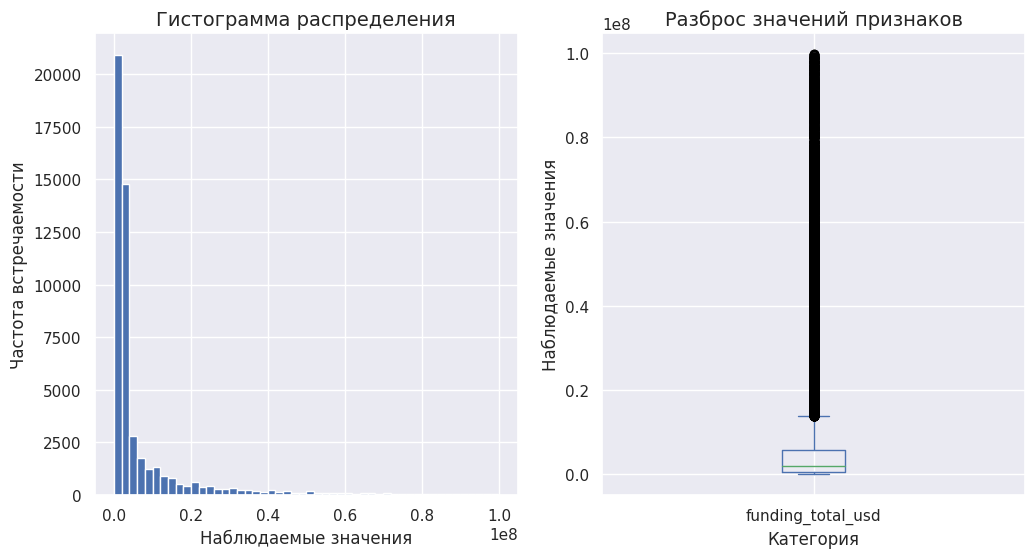

In [406]:
check_quan(train[train['funding_total_usd'] < 100000000], 'funding_total_usd', bins=50)

Гистаграмма стала немного понятнее, мы видим огромное количество стартапов с финансированием менее 1,000,000. Что и ожидалось, так как это специфика таких проектов.

Построим гистограмму распределения по признаку `funding_rounds`.

,funding_rounds
count,"52,515.000"
mean,1.741
std,1.374
min,1.000
25%,1.000
50%,1.000
75%,2.000
max,19.000


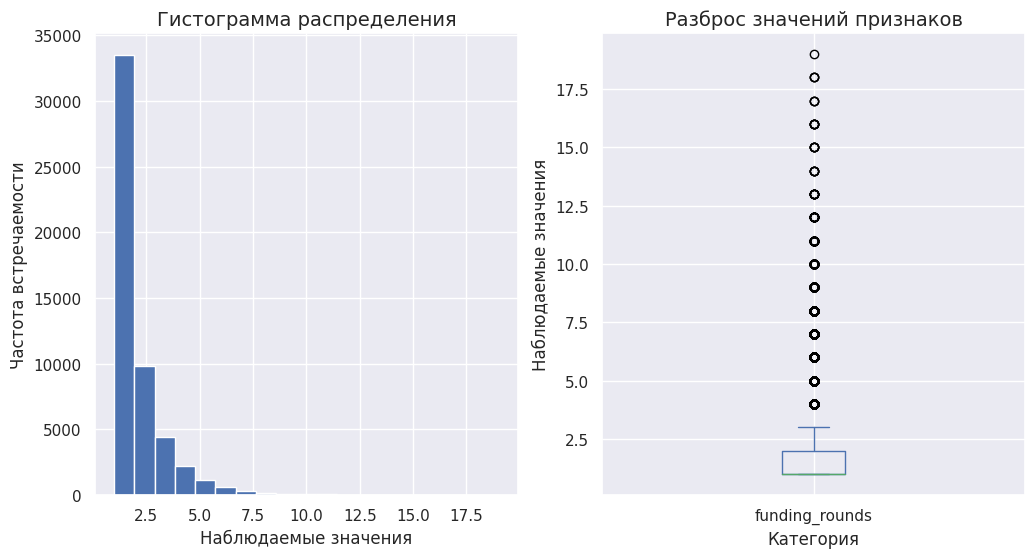

In [407]:
check_quan(train, 'funding_rounds', bins=19)

Разброс значений от 1 до 19. Медиана равна 1. Первый квантиль 1, третий 2. Мы видим выпадающие значение после трех раундов, но не будем их срезать, так как раудов финансирования может быть больше трех.

Построим гистограмму распределения по признаку `lifetime`.

,lifetime
count,"52,515.000"
mean,"3,140.650"
std,"2,147.453"
min,19.000
25%,"1,739.000"
50%,"2,557.000"
75%,"4,018.000"
max,"17,378.000"


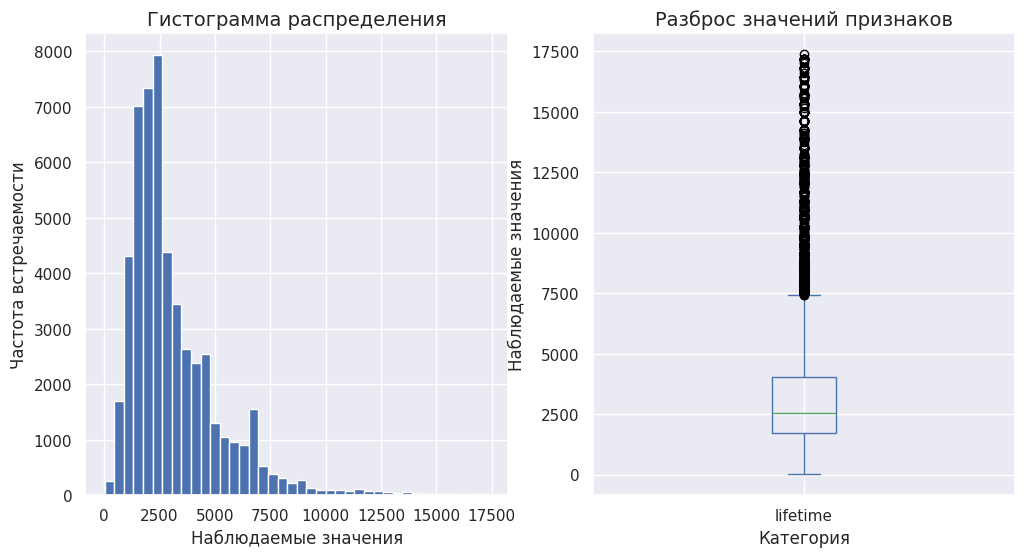

In [408]:
check_quan(train, 'lifetime', bins=40)

На гистограмме мы видим нормально распределение со смещением вправо. Разброс значений от 639 до 17,497. Медианное значение 2,649. Первый квантиль 1,826, третий 4,110. Имеются выпадающие значения свыше 7,500. Выбросами их считать не будем.

Построим гистограмму распределения по признаку `first_funding_days`.

,first_funding_days
count,"52,515.000"
mean,984.628
std,"1,649.782"
min,"-9,465.000"
25%,214.000
50%,480.000
75%,976.000
max,"16,313.000"


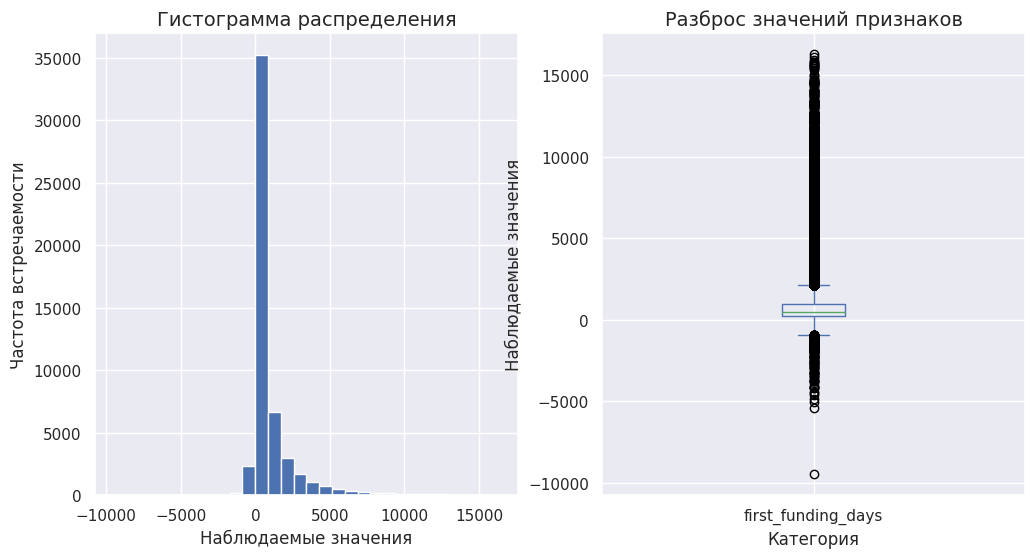

In [409]:
check_quan(train, 'first_funding_days', bins=30)

На гистограмме мы видим нормальное распределение. Имеются стартапы, где финансирование было получено раньше даты основания компании. Разброс значений от -9,465 до 16,313. В основном компании получают финансирование в первый год - полтора. Как до основания компании, так и после.

Построим гистограмму распределения по признаку `last_funding_days`.

,last_funding_days
count,"52,515.000"
mean,346.467
std,688.593
min,0.000
25%,0.000
50%,0.000
75%,427.000
max,"10,807.000"


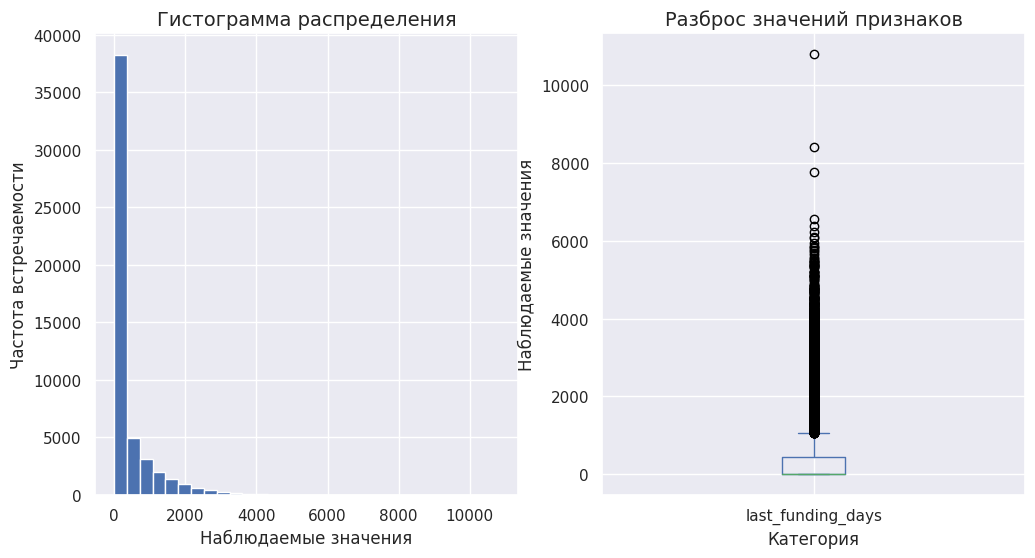

In [410]:
check_quan(train, 'last_funding_days', bins=30)

На гистаграмме мы также видим нормально распределение. Мы видим пик на нуле, для большинства компаний первый раунд финансирования является последним. Разброс значений от 0 до 10,807. Выпадающие значения более 1000 дней, однако, выбросами их считать не будем.

Построим гистограмму распределения по признаку `founded_at_year`.

,founded_at_year
count,"52,515.000"
mean,"2,008.561"
std,5.756
min,"1,970.000"
25%,"2,006.000"
50%,"2,010.000"
75%,"2,013.000"
max,"2,016.000"


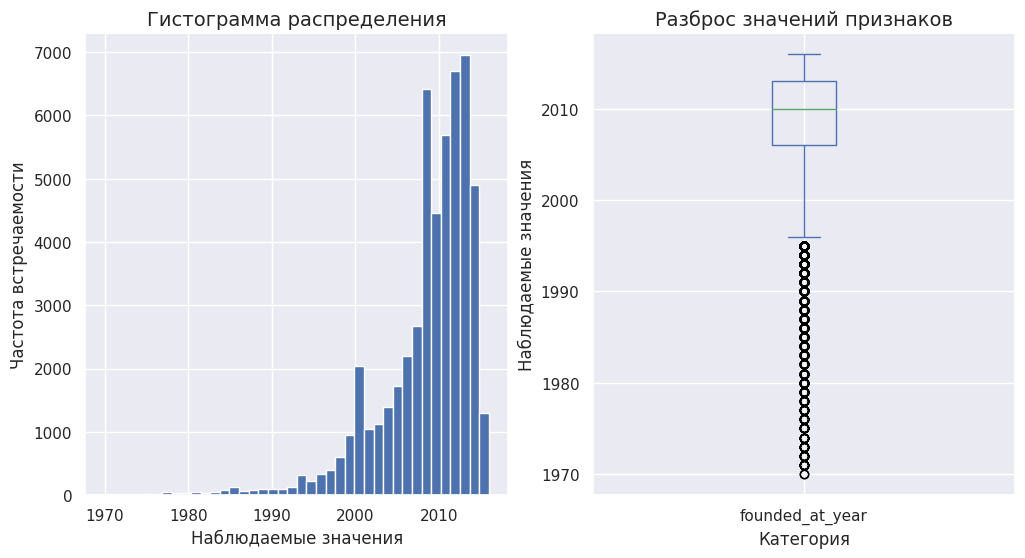

In [411]:
check_quan(train, 'founded_at_year', bins=40)

На гисторграмме мы видим, что в 2000 году был резкий рост стартапов, затем их количество упало, но продолжало расти каждый год до следующего пика в 2007-2008 году. И после 2010 года мы снова видим рост и падение после 2015.

На графике размаха мы видим стартапы, которые были открыты до 1996 года, выбросами их считать не будем.

Бум стартапов приходится на 2000 год, в целом очень хочется срезать значения, которые были до этой даты, но не будем этого делать, так как мы хотим показать модели как можно больше данных.

**Изучим категориальные признаки.**

Построим график по признаку `status`.

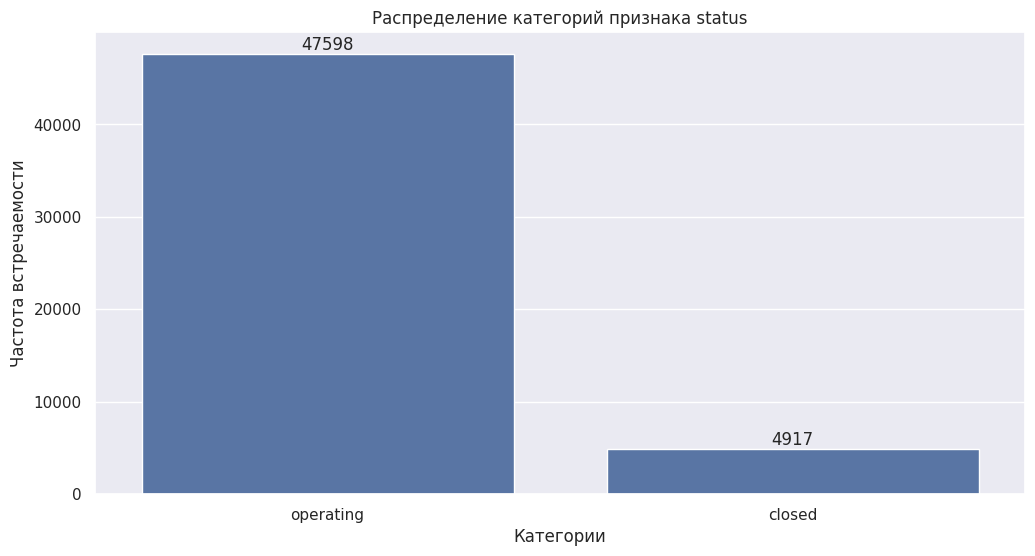

In [412]:
chek_cat_sns('status')

На графике мы видим, что целевой признак распределен не равномерно, необходимо это учесть при формировании выборки.

Так как категорий очень много, построим только топ 10.

Напишем функцию для построения графиков.

In [413]:
def chek_cat_top(cat):
    f_data = train[train[cat] != 'unknown']

    ax = sns.countplot(x=f_data[cat],
                   order=f_data[cat].value_counts(ascending=False).head(10).index);

    labels_values = f_data[cat].value_counts(ascending=False).head(10).values

    ax.bar_label(container=ax.containers[0], labels=labels_values)
    ax.set_title('Распределение категорий признака ' + cat)
    ax.set(xlabel='Категории', ylabel='Частота встречаемости')
    ax.figure.set_size_inches(20,10);

Построим график по признаку `top_categories`.

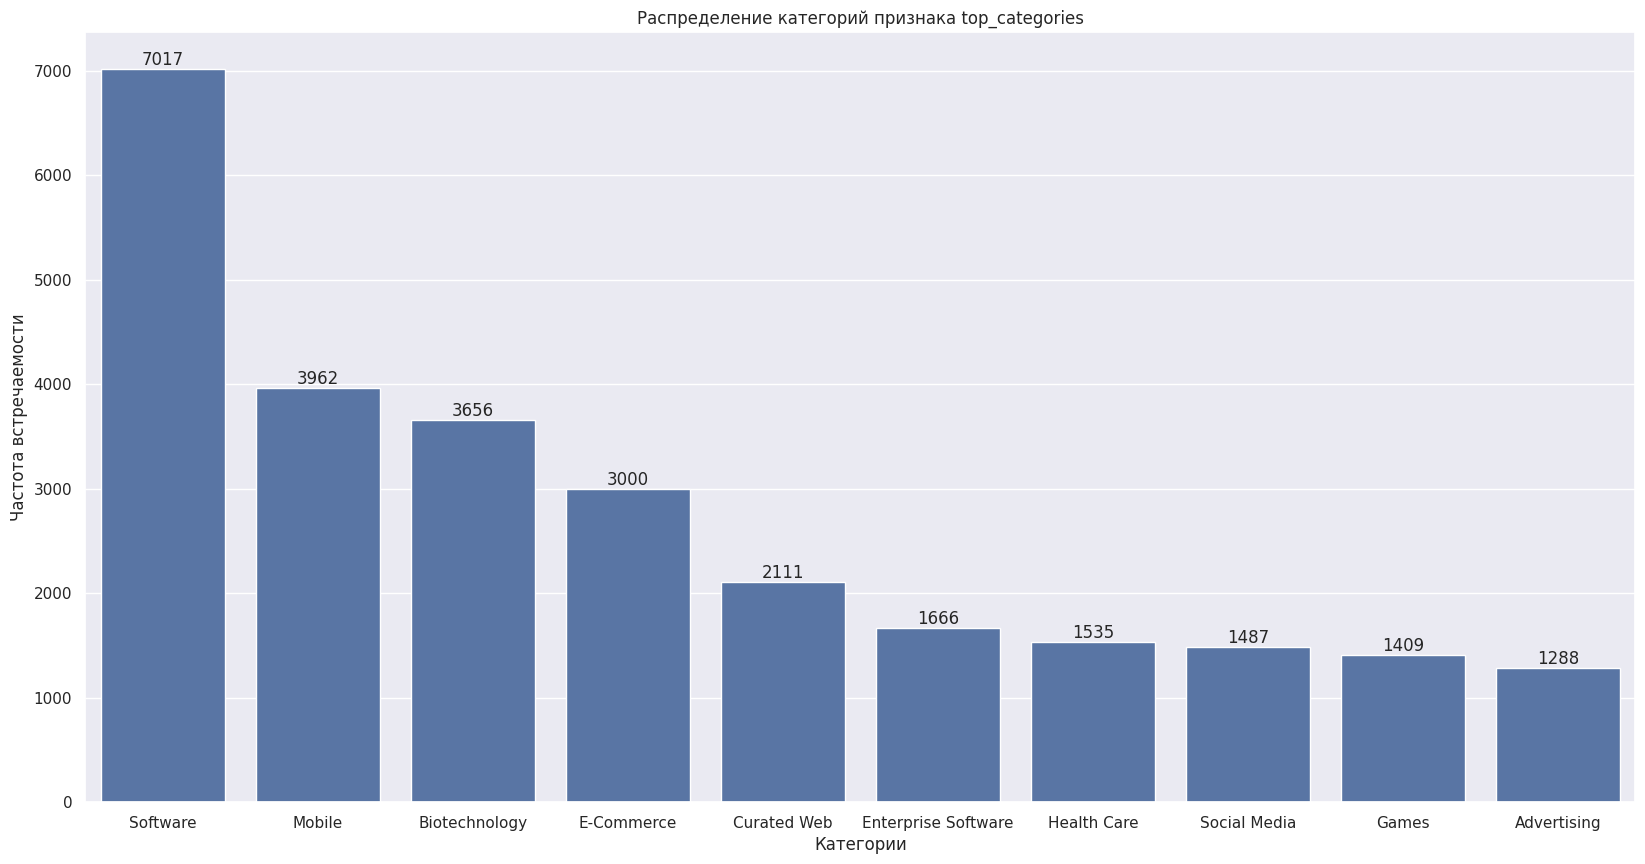

In [414]:
chek_cat_top('top_categories')

Большинство стартапов имют категорию `Software`, затем идут категории `Mobile` и `Biotechnology`.

Построим график по признаку `country_code`.

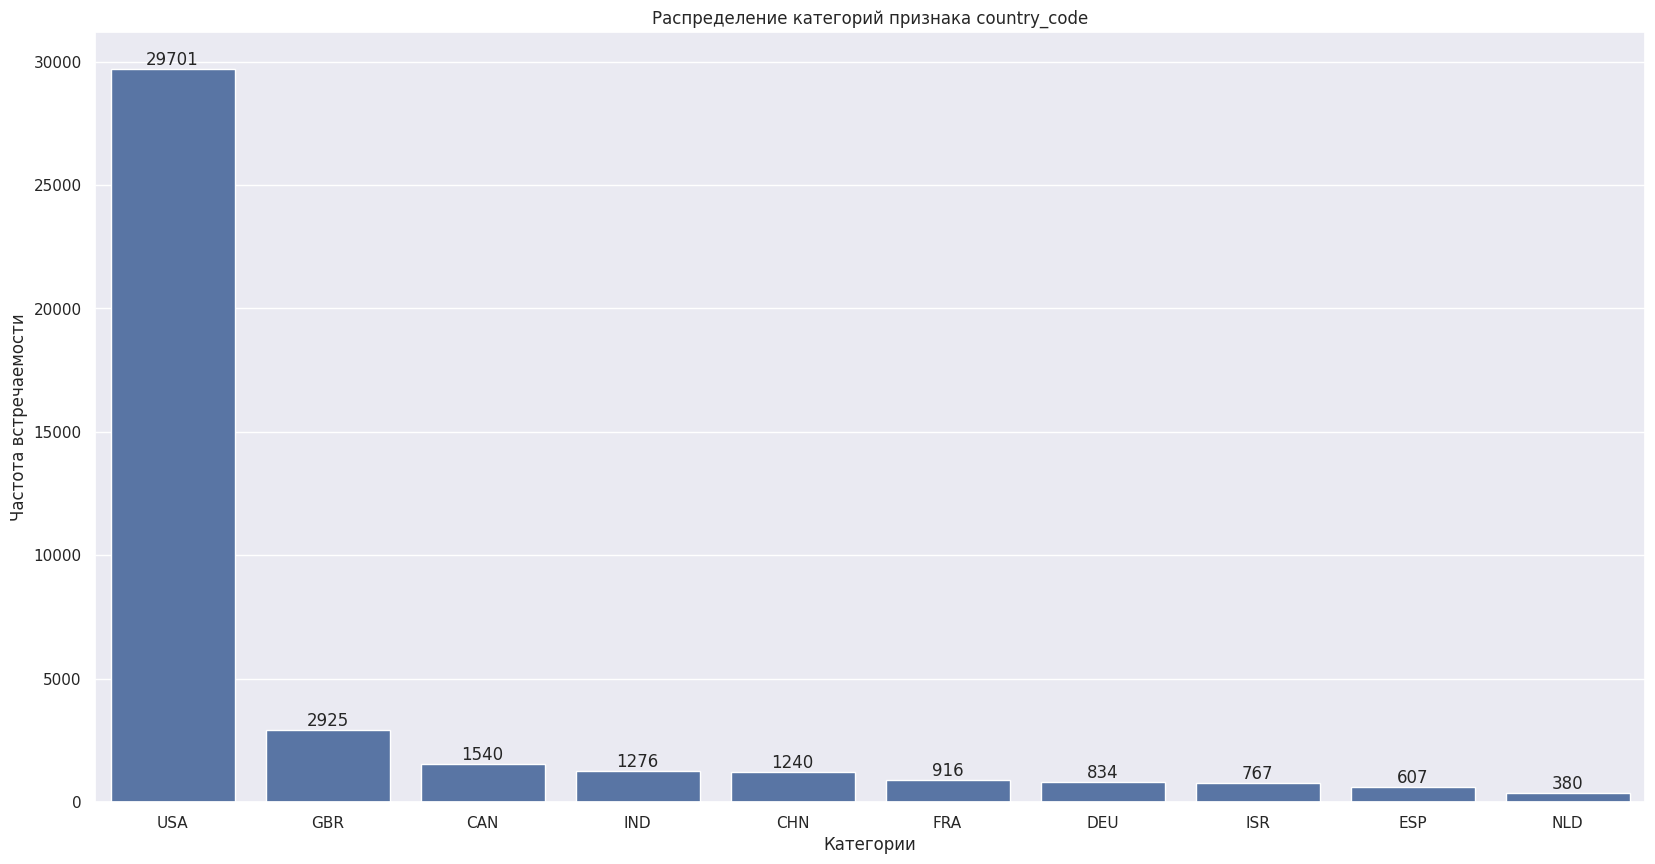

In [415]:
chek_cat_top('country_code')

Наибольшее количество стартапов было открыто в странах:
- США
- Великобритания
- Канада
- Индия
- Китай

Построим график по признаку `state_code`.

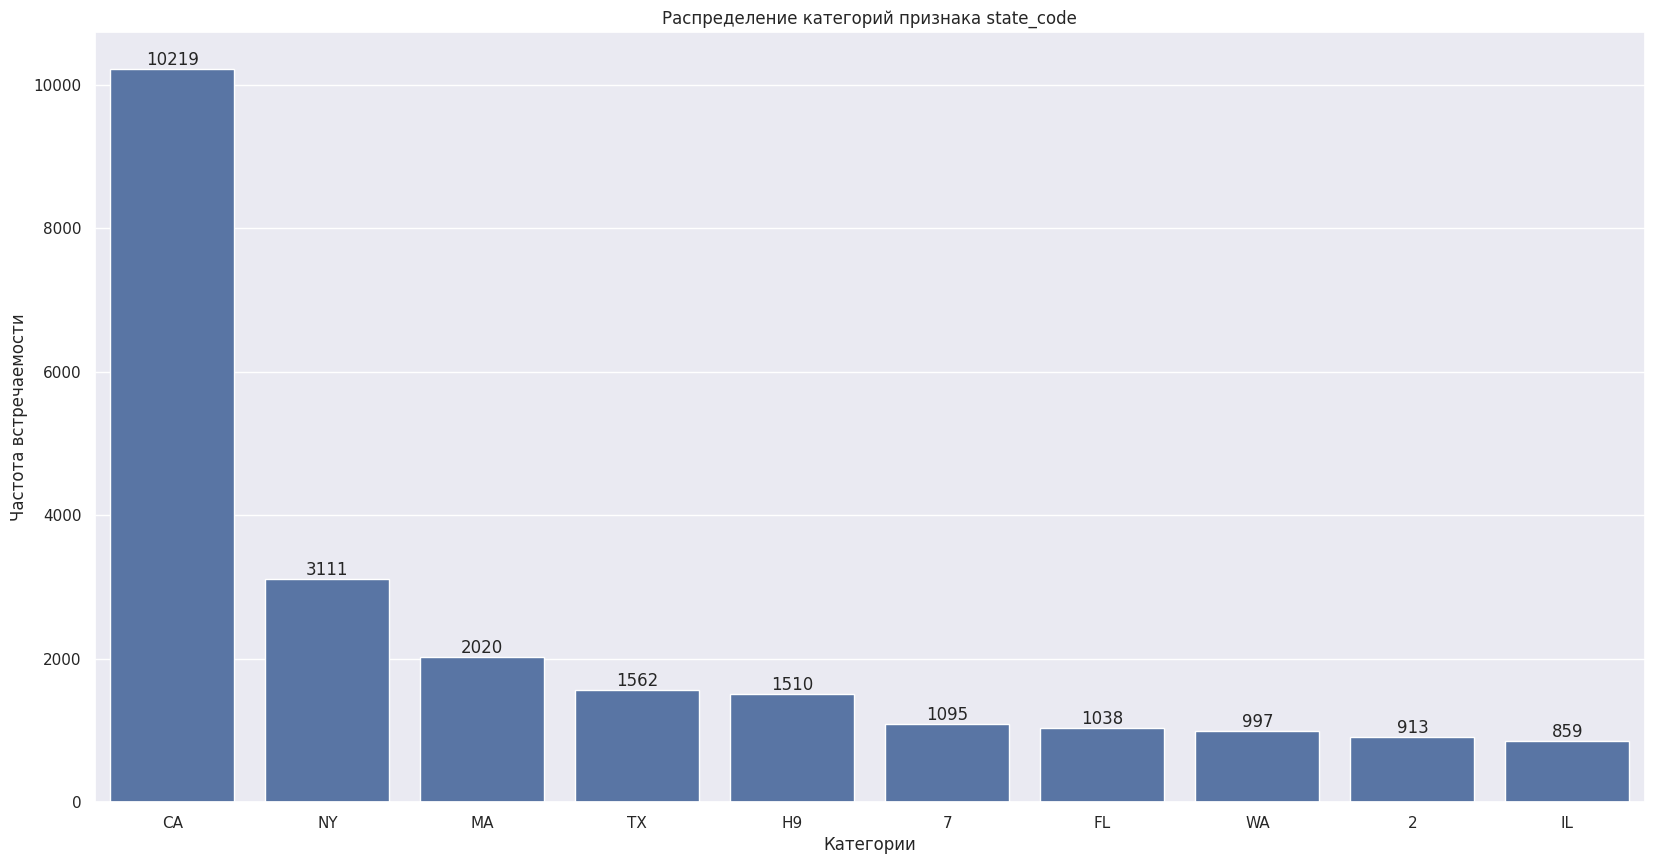

In [416]:
chek_cat_top('state_code')

Наибольшее количество стартапов было открыто в штатах:
- Калифорния (США)
- Нью-Йорк (США)
- Майями (США)
- Техас (США)

Построим график по признаку `region`.

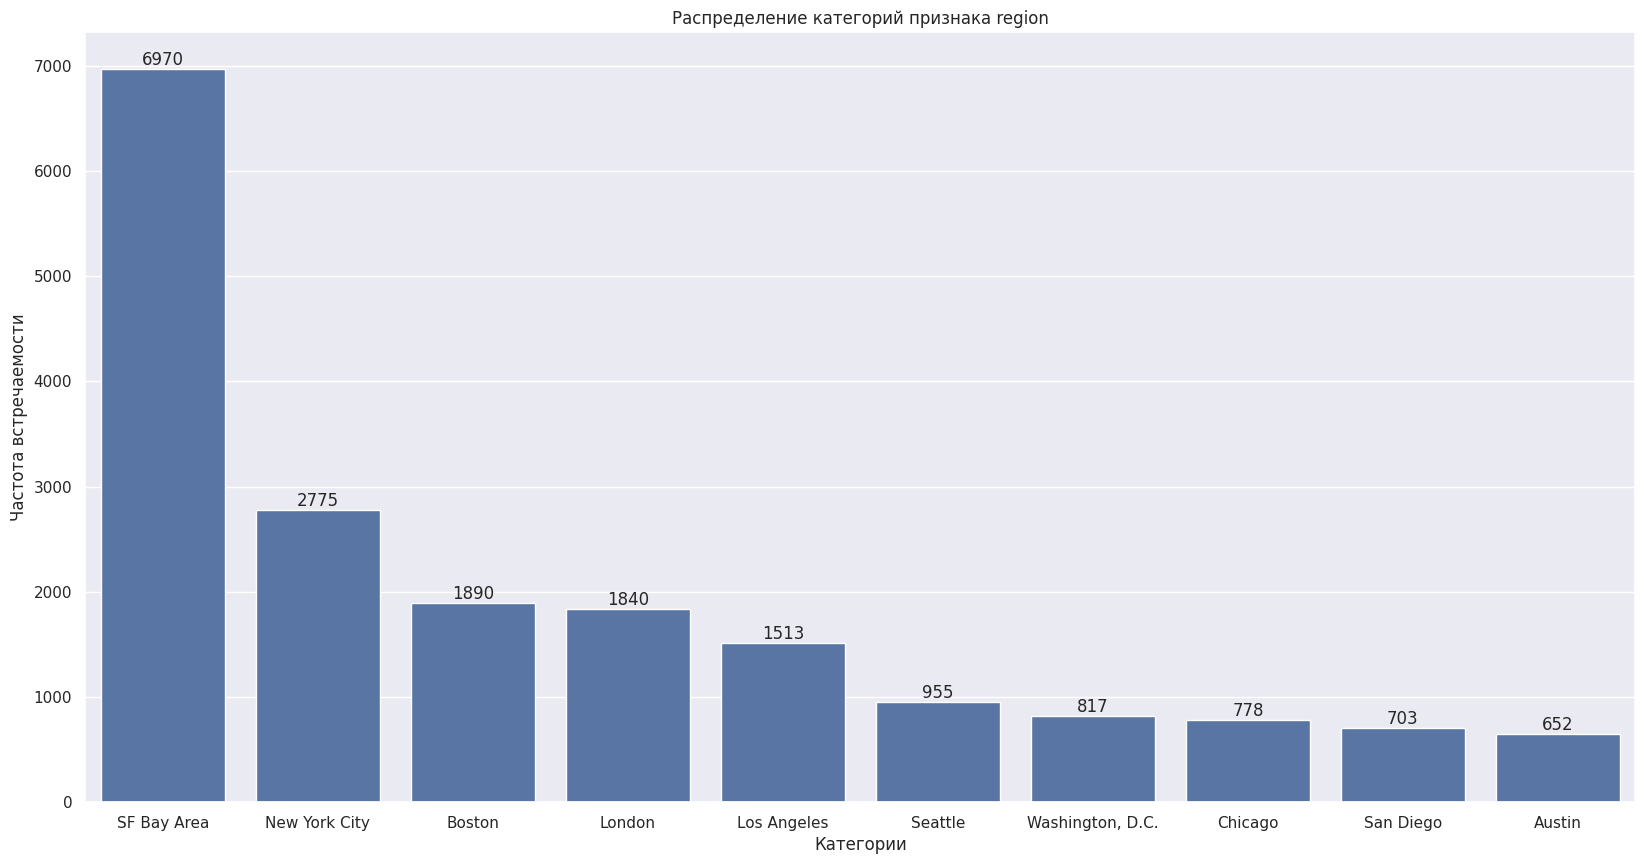

In [417]:
chek_cat_top('region')

Наибольшее количество стартапов было открыто в регионах:
- Сан-Франциско (США)
- Нью-Йорк (США)
- Бостон (США)
- Лондон (Великобритания)
- Лос-Анджелес (США)

Построим график по признаку `city`.

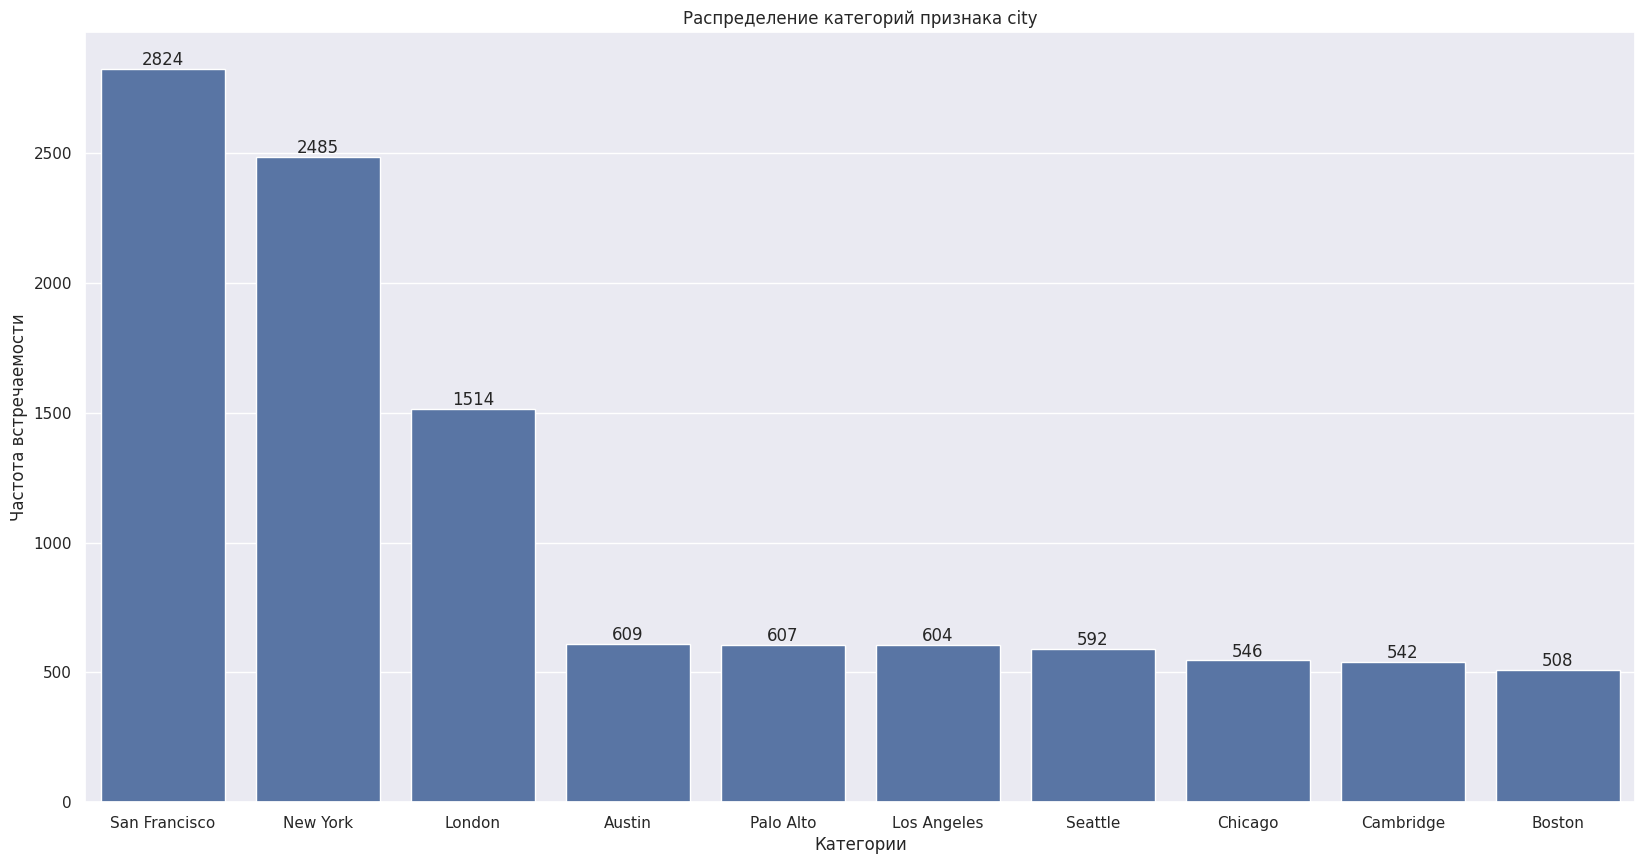

In [418]:
chek_cat_top('city')

Наибольшее количество стартапов было открыто в городах:
- Сан-Франциско (США)
- Нью-Йорк (США)
- Лондон (Великобритания)
- Остин (США)
- Пало-Алто (США)

#### Выводы.

**Исследовательский анализ данных таблицы `train`.**

Разброс значений финансирования очень велик, от 1 до 10,664,943,639. Мы видим огромное количество стартапов с финансированием менее 1,000,000. Что и ожидалось, так как это специфика таких проектов.

Разброс значений признака `funding_rounds` от 1 до 19. Медиана равна 1. Первый квантиль 1, третий 2. Мы видим выпадающие значение после трех раундов, но не будем их срезать, так как раудов финансирования может быть больше трех.

На гистограмме признака `lifetime` мы видим нормально распределение со смещением вправо. Разброс значений от 639 до 17,497. Медианное значение 2,649. Первый квантиль 1,826, третий 4,110. Имеются выпадающие значения свыше 7,500. Выбросами их считать не будем.

На гистограмме признака `first_funding_days` мы видим нормальное распределение. Имеются стартапы, где финансирование было получено раньше даты основания компании. Разброс значений от -9,465 до 16,313. В основном компании получают финансирование в первый год - полтора. Как до основания компании, так и после.

На гистаграмме признака `last_funding_days` мы также видим нормально распределение. Мы видим пик на нуле, для большинства компаний первый раунд финансирования является последним. Разброс значений от 0 до 10,807. Выпадающие значения более 1000 дней, однако, выбросами их считать не будем.

На гисторграмме признака `founded_at_year` мы видим, что в 2000 году был резкий рост стартапов, затем их количество упало, но продолжало расти каждый год до следующего пика в 2007-2008 году. И после 2010 года мы снова видим рост и падение после 2015.

На графике размаха мы видим стартапы, которые были открыты до 1996 года, выбросами их считать не будем.

Бум стартапов приходится на 2000 год, в целом очень хочется срезать значения, которые были до этой даты, но не будем этого делать, так как мы хотим показать модели как можно больше данных.

Целевой признак распределен не равномерно. Примерно 90% значений открытых стартапов и 10% закрытых.

Большинство стартапов имют категорию `Software`, затем идут категории `Mobile` и `Biotechnology`.

Наибольшее количество стартапов было открыто в странах:
- США
- Великобритания
- Канада
- Индия
- Китай

Наибольшее количество стартапов было открыто в штатах:
- Калифорния (США)
- Нью-Йорк (США)
- Майями (США)
- Техас (США)

Наибольшее количество стартапов было открыто в регионах:
- Сан-Франциско (США)
- Нью-Йорк (США)
- Бостон (США)
- Лондон (Великобритания)
- Лос-Анджелес (США)

Наибольшее количество стартапов было открыто в городах:
- Сан-Франциско (США)
- Нью-Йорк (США)
- Лондон (Великобритания)
- Остин (США)
- Пало-Алто (США)

### Корреляционный анализ.

Построим матрицу корреляции $\phi_K$.

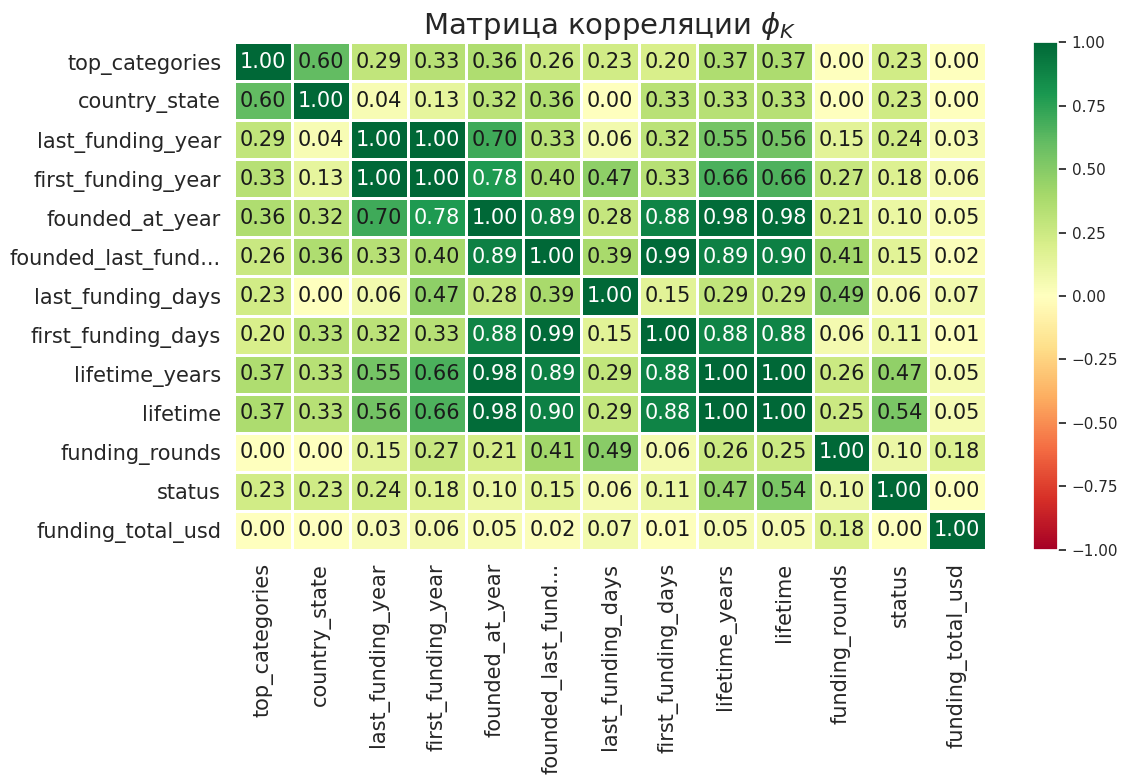

In [419]:
interval_cols = ['funding_total_usd',
                 'funding_rounds',
                 'lifetime',
                 'first_funding_days',
                 'last_funding_days',
                 'founded_at_year',
                 'founded_last_funding_days',
                 'lifetime_years',
                 'first_funding_year',
                 'last_funding_year'
                ]

phik_overview = train.drop(['name',
                            'category_list',
                            'state_code',
                            'region',
                            'city',
                            'founded_at',
                            'first_funding_at',
                            'last_funding_at',
                            'closed_at',
                            'country_code'
                           ], axis=1).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Матрица корреляции $\phi_K$",
    fontsize_factor=1.5,
    figsize=(12, 8)
)

На матрице корреляции мы видим очень слабую зависимость целевого признака от признаков, которые не связаны с датами. Удалим их из датасетов.

Выявлена мультиколлениарность признаков:
- `first_funding_year` и `last_funding_year`, оставим `last_funding_year`
- `lifetime_years`, `lifetime` и `founded_at_year`, оставим `lifetime`
-  `first_funding_days` и `founded_last_funding_days`, оставим `first_funding_days`

Построим матрицу корреляции по выбранным столбцам.

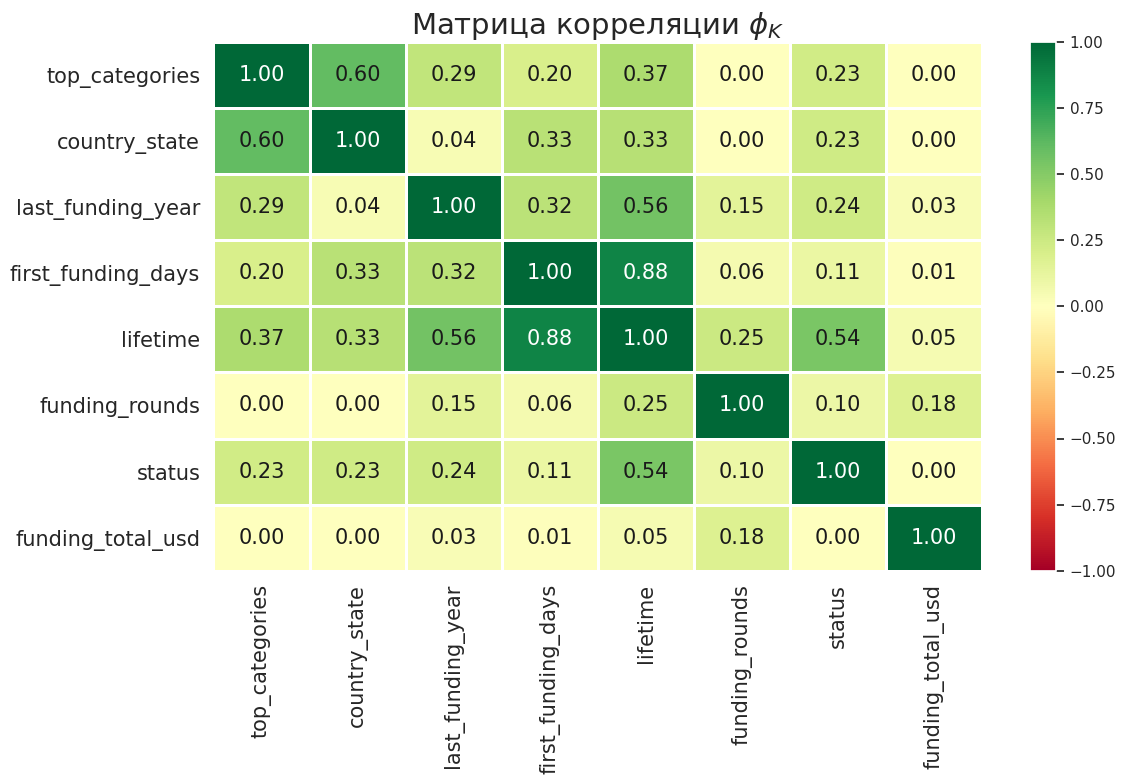

In [420]:
interval_cols_final = [
                 'last_funding_year',
                 'lifetime',
                 'first_funding_days',
                 'funding_rounds',
                 'funding_total_usd',
                ]

phik_overview = train.drop(['name',
                            'category_list',
                            'state_code',
                            'region',
                            'city',
                            'founded_at',
                            'first_funding_at',
                            'last_funding_at',
                            'closed_at',
                            'country_code',
                            'lifetime_years',
                            'founded_at_year',
                            'founded_last_funding_days',
                            'first_funding_year',
                            'last_funding_days'
                           ], axis=1).phik_matrix(interval_cols=interval_cols_final)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Матрица корреляции $\phi_K$",
    fontsize_factor=1.5,
    figsize=(12, 8)
)

Мультиколлениарность устранена. Отберем данные признаки для обучения моделей.

### Подготовка данных.

Удалим признаки из тренировочного датасета.

In [421]:
train = train.drop(['name',
                    'category_list',
                    'state_code',
                    'region',
                    'city',
                    'founded_at',
                    'first_funding_at',
                    'last_funding_at',
                    'closed_at',
                    'country_code',
                    'lifetime_years',
                    'founded_at_year',
                    'founded_last_funding_days',
                    'first_funding_year',
                    'last_funding_days'
                           ], axis=1)

Проверим результат.

In [422]:
train.head(2)

,funding_total_usd,status,funding_rounds,lifetime,first_funding_days,last_funding_year,country_state,top_categories
0,"828,626.000",operating,2,"2,998.000",561,2014,CHE25,Restaurants
1,"42,935,019.000",operating,4,"4,748.000",1949,2014,USACA,Manufacturing


Удалим признаки из тестового датасета.

In [423]:
test = test.drop([
                    'category_list',
                    'state_code',
                    'region',
                    'city',
                    'founded_at',
                    'first_funding_at',
                    'last_funding_at',
                    'country_code',
                    'lifetime_years',
                    'founded_at_year',
                    'founded_last_funding_days',
                    'first_funding_year',
                    'last_funding_days'
                           ], axis=1)

Проверим результат.

In [424]:
test.head(2)

,name,funding_total_usd,funding_rounds,lifetime,first_funding_days,last_funding_year,country_state,top_categories
0,Crystalsol,"2,819,200.000",1,3501,395,2009,NIC17,Clean Technology
1,JBI Fish & Wings,"2,000,000.000",1,2717,3,2010,USATN,Hospitality


Закодируем целевой признак вручную: закрылся -1, открыт - 0.

In [425]:
train['status_01'] = \
train['status'].apply(lambda x: 0 if x=='operating' else 1)

Поделим данные тренировочной таблицы на целевой и входящие признаки.

In [426]:
X_train, X_valid, y_train, y_valid = train_test_split(train.drop([
                                                                  'status',
                                                                  'status_01',
                                                                   ], axis=1),
                                                      train['status_01'],
                                                      test_size=0.2,
                                                      random_state=42,
                                                      stratify=train['status_01']
                                                      )
X_test = test.drop(['name'], axis=1)

Создадим списки с названиями признаков.

In [427]:
ord_columns = ['top_categories', 'country_state']

num_columns = X_train.select_dtypes(include='number').columns.tolist()

Собираем пайплайн.

In [428]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

### Обучение моделей.

Выбираем модели и их параметры.

In [429]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 31),
        'models__max_features': range(2, 31),
        'models__min_samples_split': range(1, 15),
        'models__min_samples_leaf': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='saga',
            penalty='l1'
        )],
        'models__C': [0.01, 0.1, 1, 2, 3, 4, 5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },

    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel' : ['rbf', 'sigmoid'],
        'models__C': [0.01, 0.1, 1, 2, 3, 4, 5, 6],
        'models__gamma': [0.01, 0.1, 1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

Для поиска лучшей модели и ее параметров применим RandomizedSearchCV.

In [430]:
rand_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    n_iter=100
)

In [431]:
rand_search.fit(X_train, y_train);

In [432]:
print('Лучшая модель и её параметры:\n\n', rand_search.best_params_)

Лучшая модель и её параметры:

 {'preprocessor__num': StandardScaler(), 'models__min_samples_split': 6, 'models__min_samples_leaf': 4, 'models__max_features': 14, 'models__max_depth': 30, 'models': DecisionTreeClassifier(random_state=42)}


In [433]:
print('Метрика лучшей модели на кросс-валидационной выборке:', rand_search.best_score_)

Метрика лучшей модели на кросс-валидационной выборке: 0.941243597524343


In [434]:
y_pred_valid = rand_search.predict(X_valid)
print(f'Метрика F1 на валидационной выборке: {f1_score(y_valid, y_pred_valid)}')

Метрика F1 на валидационной выборке: 0.9438320209973753


**Применим OptunaSearchCV для поиска лучших параметров модели RandomForestClassifier.**

Соберем новый пайплайн для модели RandomForestClassifier.

In [435]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков + Ordinal-кодирование
ord_pipe_forest = Pipeline(
    [('simpleImputer_before_ord',
      SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Unknown')),

     ('ord',
      OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),

     ('simpleImputer_after_ord',
      SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-900))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor_forest = ColumnTransformer(
    [('ord', ord_pipe_forest, ord_columns),
     ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_forest = Pipeline([
    ('preprocessor', data_preprocessor_forest),
    ('models', RandomForestClassifier(random_state=RANDOM_STATE))
])

# выбираем параметры
parameters_forest = {
    'models__max_depth': distributions.IntDistribution(2, 35),
    'models__min_samples_split': distributions.IntDistribution(2, 30),
    'models__max_features': distributions.IntDistribution(1, 20),
    'models__min_samples_leaf': distributions.IntDistribution(1, 10),
}

oscv_forest = OptunaSearchCV(
    pipe_final_forest,
    parameters_forest,
    scoring='f1',
    cv=5,
    n_trials=10,
    random_state=RANDOM_STATE
)

In [436]:
oscv_forest.fit(X_train, y_train)

[I 2024-08-08 11:14:37,797] A new study created in memory with name: no-name-00c579d0-0d30-4450-8488-d436f8d30cd8
[I 2024-08-08 11:15:02,866] Trial 0 finished with value: 0.9160668848391508 and parameters: {'models__max_depth': 17, 'models__min_samples_split': 26, 'models__max_features': 2, 'models__min_samples_leaf': 4}. Best is trial 0 with value: 0.9160668848391508.
[I 2024-08-08 11:15:51,994] Trial 1 finished with value: 0.9503079378846561 and parameters: {'models__max_depth': 18, 'models__min_samples_split': 10, 'models__max_features': 5, 'models__min_samples_leaf': 2}. Best is trial 1 with value: 0.9503079378846561.
[I 2024-08-08 11:16:33,556] Trial 2 finished with value: 0.9178389022242627 and parameters: {'models__max_depth': 7, 'models__min_samples_split': 11, 'models__max_features': 7, 'models__min_samples_leaf': 10}. Best is trial 1 with value: 0.9503079378846561.
[I 2024-08-08 11:17:34,202] Trial 3 finished with value: 0.9496186632629786 and parameters: {'models__max_depth'

OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('ord',
                                                                           Pipeline(steps=[('simpleImputer_before_ord',
                                                                                            SimpleImputer(fill_value='Unknown',
                                                                                                          strategy='constant')),
                                                                                           ('ord',
                                                                                            OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                           unknown_value=nan)),
                                                                                           ('simpleImputer_after_ord',
                                                                                            SimpleImputer(fill_v...
               n_jobs=1,
               param_distributions={'models__max_depth': IntDistribution(high=35, log=False, low=2, step=1),
                                    'models__max_features': IntDistribution(high=20, log=False, low=1, step=1),
                                    'models__min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1),
                                    'models__min_samples_split': IntDistribution(high=30, log=False, low=2, step=1)},
               random_state=42, scoring='f1')

Выведем на экран лучшие параметры.

In [437]:
oscv_forest.best_params_

{'models__max_depth': 18,
 'models__min_samples_split': 10,
 'models__max_features': 5,
 'models__min_samples_leaf': 2}

Выведем на экран метрику модели на кросс-валидационной выборке.

In [438]:
print('Метрика модели на кросс-валидационной выборке:', oscv_forest.best_score_)

Метрика модели на кросс-валидационной выборке: 0.9503079378846561


Выведем на экран метрику модели на валидационной выборке.

In [448]:
y_pred_forest_valid = oscv_forest.predict(X_valid)
print(f'Метрика на валидационной выборке F1: {f1_score(y_valid, y_pred_forest_valid)}')

Метрика на валидационной выборке F1: 0.957074721780604


**Обучим новую модель для предсказаний - CatBoostClassifier.**

In [440]:
#делим данные на выборки
X_train_c, X_valid_c, y_train_c, y_valid_c =\
train_test_split(train.drop(['status',
                             'status_01',
                             'funding_total_usd',
                             'funding_rounds'
                             ], axis=1),
                 train['status_01'],
                 test_size=0.2,
                 random_state=42)

X_test_c = test.drop(['name',
                      'funding_total_usd',
                      'funding_rounds'], axis=1)

#применим к датасету оверсэмплинг
ov_sampler = RandomOverSampler()
X_train_c, y_train_c = ov_sampler.fit_resample(X_train_c, y_train_c)

#задаем категориальные столбцы
cat_features = [
                'top_categories',
                'country_state'
                ]

#делим данные на тренировчную и валидационную выборки
data_train = Pool(data=X_train_c, label=y_train_c, cat_features=cat_features)
data_eval = Pool(data=X_valid_c, label=y_valid_c, cat_features=cat_features)

#создаем модель
model_cat = CatBoostClassifier(
    learning_rate=0.1,
    iterations=1000,
    use_best_model=True,
    eval_metric="TotalF1",
    loss_function="Logloss",
    early_stopping_rounds=20,
    random_seed=42
    )

In [441]:
model_cat.fit(data_train, eval_set=data_eval)

0:	learn: 0.8913228	test: 0.9580352	best: 0.9580352 (0)	total: 77.4ms	remaining: 1m 17s
1:	learn: 0.9182152	test: 0.9638022	best: 0.9638022 (1)	total: 148ms	remaining: 1m 13s
2:	learn: 0.9238997	test: 0.9684725	best: 0.9684725 (2)	total: 230ms	remaining: 1m 16s
3:	learn: 0.9253571	test: 0.9684590	best: 0.9684725 (2)	total: 342ms	remaining: 1m 25s
4:	learn: 0.9286939	test: 0.9699270	best: 0.9699270 (4)	total: 423ms	remaining: 1m 24s
5:	learn: 0.9256599	test: 0.9661295	best: 0.9699270 (4)	total: 495ms	remaining: 1m 22s
6:	learn: 0.9292490	test: 0.9676538	best: 0.9699270 (4)	total: 572ms	remaining: 1m 21s
7:	learn: 0.9308846	test: 0.9705997	best: 0.9705997 (7)	total: 653ms	remaining: 1m 20s
8:	learn: 0.9300723	test: 0.9708246	best: 0.9708246 (8)	total: 721ms	remaining: 1m 19s
9:	learn: 0.9333422	test: 0.9722258	best: 0.9722258 (9)	total: 801ms	remaining: 1m 19s
10:	learn: 0.9317398	test: 0.9714506	best: 0.9722258 (9)	total: 872ms	remaining: 1m 18s
11:	learn: 0.9330300	test: 0.9749108	best

In [442]:
cv_data = data_eval
cv_scores_cat = cv(
    cv_data,
    model_cat.get_params(),
    fold_count=5,
    plot=True,
    shuffle=True,
    logging_level="Silent",
)

print('CV score: {:.5f}'.format(cv_scores_cat['test-TotalF1-mean'].values[-1]))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CV score: 0.98449


Результат работы модели:
- на валидационной выборке = 0.984
- на кросс-валидационной выборке = 0.984

Выведем на экран результаты работы моделей и выберем из них лучшую.

In [443]:
print('DecisionTreeClassifier:')
print(f'Метрика F1 модели на валидационной выборке: {f1_score(y_valid, y_pred_valid)}')

print('\n\nRandomForestClassifier:')
print(f'Метрика F1 модели на валидационной выборке: {f1_score(y_valid, y_pred_forest_valid)}')

print('\n\nCatBoostClassifier:')
print('Метрика F1 модели на валидационной выборке: {:.5f}'.format(cv_scores_cat['test-TotalF1-mean'].values[-1]))

DecisionTreeClassifier:
Метрика F1 модели на валидационной выборке: 0.9438320209973753


RandomForestClassifier:

Метрика F1 модели на валидационной выборке: 0.957074721780604


CatBoostClassifier:

Метрика F1 модели на валидационной выборке: 0.98449


Лучше всего себя показала модель CatBoostClassifier, выберем ее для получения предсказаний на тестовой выборке.

Запишем результат предсказаний в переменную `result`.

In [444]:
y_pred_cat = model_cat.predict(X_test_c)

test['status_cat_01'] = y_pred_cat
test['status'] = test['status_cat_01'].apply(lambda x: 'operating' if x==0 else 'closed')

result = test[['name', 'status']]

In [449]:
#result.to_csv('result10.csv', index = False)

Анализ важности признаков.

In [445]:
#создаём explainer
explainer = shap.TreeExplainer(model_cat)

#получаем значения Шепли
shap_values = explainer(X_valid_c)

Построим диаграмму `shap.plots.bar`.

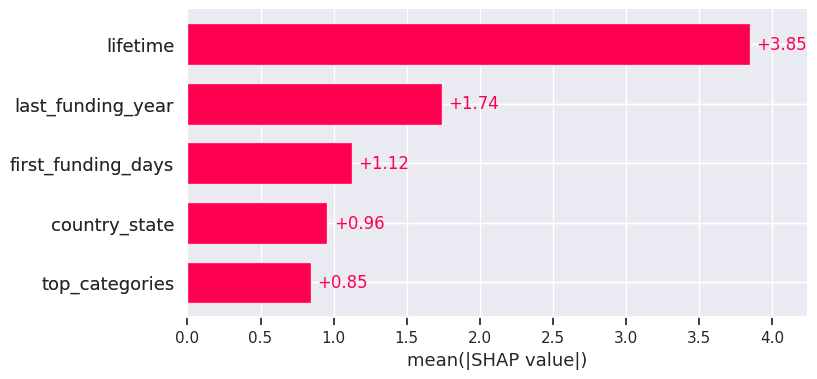

In [446]:
shap.plots.bar(shap_values)

На диаграмме мы видим, что временные признаки наиболее важны для модели, чем признаки с категориями.

### Выводы.

**Обзор данных.**

В таблице `train` во всех столбцах, кроме `funding_rounds`, `founded_at`, `first_funding_at` и `last_funding_at` есть пропущеные значения. Необходимо изменить типы данных в столбцах `founded_at`, `first_funding_at`, `last_funding_at` и `closed_at` на `datetime64`.

В таблице `test` во всех столбцах кроме `name`, `funding_rounds`, `first_funding_at`, `last_funding_at` и `lifetime` есть пропущеные значения. Необходимо изменить типы данных в столбцах `first_funding_at` и `last_funding_at` на `datetime64`.

**Предобработка данных.**

В таблице `train` пропущенные значения в столбцах `name`, `category_list`, `country_code`, `state_code`, `region` и `city`, заполнили заглушкой. Столбец `funding_total_usd` заполнили медианой.

В таблице `test` пропущенные значения в столбцах `category_list`, `country_code`, `state_code`, `region` и `city`, заполнили заглушкой. Столбец `funding_total_usd` заполнили медианой.

Явных дубликатов в таблицах не обнаружено.

В таблицах неявных дубликатов не обнаружено.

В таблице `test` изменены типы данных в столбцах `first_funding_at`, `last_funding_at` на `datetime64`.

В таблице `train` изменены типы данных в столбцах `founded_at`, `first_funding_at`, `last_funding_at` и `closed_at` на `datetime64`.

Удален выброс в столбце `funding_total_usd` в таблице `train`.

Добавлен столбец `country_state`, в котором содержится информация с кодом страны и кодом штата.

Добавлен столбец `top_categories`, который содержит самую популярную категорию из указанных компанией.

Добавлены сталбцы с различными вариантами отоброжения значений даты.

**Исследовательский анализ данных таблицы `train`.**

Разброс значений финансирования очень велик, от 1 до 10,664,943,639. Мы видим огромное количество стартапов с финансированием менее 1,000,000. Что и ожидалось, так как это специфика таких проектов.

Разброс значений признака `funding_rounds` от 1 до 19. Медиана равна 1. Первый квантиль 1, третий 2. Мы видим выпадающие значение после трех раундов, но не будем их срезать, так как раудов финансирования может быть больше трех.

На гистограмме признака `lifetime` мы видим нормально распределение со смещением вправо. Разброс значений от 639 до 17,497. Медианное значение 2,649. Первый квантиль 1,826, третий 4,110. Имеются выпадающие значения свыше 7,500. Выбросами их считать не будем.

На гистограмме признака `first_funding_days` мы видим нормальное распределение. Имеются стартапы, где финансирование было получено раньше даты основания компании. Разброс значений от -9,465 до 16,313. В основном компании получают финансирование в первый год - полтора. Как до основания компании, так и после.

На гистаграмме признака `last_funding_days` мы также видим нормально распределение. Мы видим пик на нуле, для большинства компаний первый раунд финансирования является последним. Разброс значений от 0 до 10,807. Выпадающие значения более 1000 дней, однако, выбросами их считать не будем.

На гисторграмме признака `founded_at_year` мы видим, что в 2000 году был резкий рост стартапов, затем их количество упало, но продолжало расти каждый год до следующего пика в 2007-2008 году. И после 2010 года мы снова видим рост и падение после 2015.

На графике размаха мы видим стартапы, которые были открыты до 1996 года, выбросами их считать не будем.

Бум стартапов приходится на 2000 год, в целом очень хочется срезать значения, которые были до этой даты, но не будем этого делать, так как мы хотим показать модели как можно больше данных.

Целевой признак распределен не равномерно. Примерно 90% значений открытых стартапов и 10% закрытых.

Большинство стартапов имют категорию `Software`, затем идут категории `Mobile` и `Biotechnology`.

Наибольшее количество стартапов было открыто в странах:
- США
- Великобритания
- Канада
- Индия
- Китай

Наибольшее количество стартапов было открыто в штатах:
- Калифорния (США)
- Нью-Йорк (США)
- Майями (США)
- Техас (США)

Наибольшее количество стартапов было открыто в регионах:
- Сан-Франциско (США)
- Нью-Йорк (США)
- Бостон (США)
- Лондон (Великобритания)
- Лос-Анджелес (США)

Наибольшее количество стартапов было открыто в городах:
- Сан-Франциско (США)
- Нью-Йорк (США)
- Лондон (Великобритания)
- Остин (США)
- Пало-Алто (США)

**Корреляционный анализ.**

На матрице корреляции мы обнаружили очень слабую зависимость целевого признака от признаков, которые не связаны с датами. Удалили их из таблиц.

Выявлена мультиколлениарность признаков:
- `first_funding_year` и `last_funding_year`, оставим `last_funding_year`
- `lifetime_years`, `lifetime` и `founded_at_year`, оставим `lifetime`
-  `first_funding_days` и `founded_last_funding_days`, оставим `first_funding_days`

Мультиколлениарность устранена. Отобрали признаки для обучения моделей.

**Обучение моделей.**

Для обучения было выбрано три разных подхода.

Первый.
Выбор базовых моделей: DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression и SVC.
Поиск лучшей модели и ее параметров проводился с помощью RandomizedSearchCV. Лучше всего справилась модель DecisionTreeClassifier с результатом метрики на валидационной выборке F1=0.9438.

Второй.
Обучение модели RandomForestClassifier и поиск лучших параметров с помощью OptunaSearchCV. Результат работы модели на валидационной выборке с лучшими параметрами составил: F1=0.9570.

Третий.
Обучение модели CatBoostClassifier и подбор признаков для обучения. В итоговой модели были удалены признаки `funding_total_usd` и `funding_rounds`, так как они не вносили большого вклада в работу модели и итоговый результат становился хуже. Результатом работы модели на валидационной выборке стала метрика F1=0.9845.


Лучше всего себя показала модель CatBoostClassifier.


При анализе важности признаков мы подтвердили, что временные признаки наиболее важны для модели, чем признаки с категориями.